In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import copy
import time
import sys
import math
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)
rng = np.random.default_rng()

# Simulate weights in biparental Moran model

In [2]:
def simulate_weights_coupled(p=[0.5], N=1000, n=1000000, idealized=False, Weights="None"):
    """
    Simulates coupled weights for same reproduction events for different values of the paternal bias p
    (backwards in time). The Model is a biparental Moran model.
    
            Parameters:
                    p (float or list of floats in [0,1]): Portion of any individual's weight that splits off to mother.
                    N (int): Population size.
                    n (int): Number of time steps.
                    idealized (bool): If 'True', coupled idealized process (for p=1/N^2) is simulated.
                    Weights (real np.array of shape (len[p]+idealized,N)): Starting weights of population.  
                    Previously simulated weights can be inserted to continue the simulation.
                    
            Returns:
                    Weights (list of np_arrays of shape (len[p]+idealized,N)): List of weights of population n time 
                    steps in the past for all values of p. Idealized weights are last.
    
    """
    if isinstance(p, float): 
        p = [p]
    num_experiments = len(p) #Number of separate weight vectors are needed
    
    if idealized: #Algorithm is different for idealized weights
        if Weights == "None": #If no starting weights are given, they are generated as the weights of the population at time 0
            Weights = np.ones(shape=(num_experiments+1, N))
            for j in range(N-1):
                Weights[num_experiments][j] = 0
            Weights[num_experiments] = Weights[num_experiments]*N
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:") #Plots progress bar
        clear_output(wait=True)
        
        for i in range(n): #Simulates weights over n time steps
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments): #First block: Transition of weight process. Second block: Transition of idealized
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if Weights[num_experiments][kappa] > Weights[num_experiments][mu]: 
                Weights[num_experiments][mu] = Weights[num_experiments][kappa]
            if Weights[num_experiments][kappa] > Weights[num_experiments][pi]:
                Weights[num_experiments][pi] = Weights[num_experiments][kappa]/(N**2)
            Weights[num_experiments][kappa] = 0
            
            if (i % 10000) == 0: #Updates progress bar every 10.000 tiem steps
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
    else: #Same algorithm without idealized weights
        if Weights == "None":
            Weights = np.ones(shape=(num_experiments, N))
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:")
        clear_output(wait=True)
        
        for i in range(n):
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments):
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if (i % 10000) == 0:
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
                
    print("Simulating weights: 100%")
    clear_output(wait=True)
    
    return Weights

In [3]:
def simulate_weights_fast(p=0.5, N=1000, n=1000000):
    """
    Simulates weights for a biparental Moran model with parental bias p. Only slightly faster because progress bar is less 
    accurate.
    """
    Weights = np.ones(N)
    indices = np.arange(0, N, 1, dtype=int)
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa] = 0
        if (i % 100000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    return Weights

### Example 1

In [44]:
start = time.time()

N = 100
n = 10000

indices = np.arange(0, N, 1, dtype=int)
weights = simulate_weights_coupled(N=N, n=n)[0] #Simulates weights for both parents contributing equally (p=1/2)
weights.sort()

end = time.time()
print(str(round(end-start)) + " seconds")
print("Maximum weight: " + str(np.max(weights)))
print("Number of zero-weights: " + str(np.where(weights != 0)[0][0]))

0 seconds
Maximum weight: 7.780222726256613
Number of zero-weights: 45


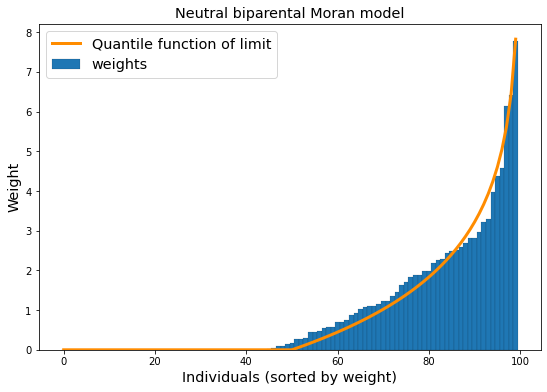

In [46]:
plt.bar(indices, weights, width=1, linewidth=0.1, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Neutral biparental Moran model", fontsize="x-large")

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(9, 6)

#This part plots the Quantile function corresponding to the Limit (n,N -> inf) found by Camille Coron & Yves Le Jan
Quantiles = -(2)*np.log(2*(1-indices[int((N*0.5)):]/N))
y = list(np.zeros(int((N*0.5))))
y.extend(Quantiles)
plt.plot(indices, y, linewidth=3, color="darkorange", label="Quantile function of limit")
plt.legend(fontsize="x-large")

### Example 2

In [25]:
start = time.time()

N = 1000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
weights_coupled = simulate_weights_coupled(p=[0.1,0.01,0.001], N=N, n=n)
"Simulates coupled weights for small values of p"
weights_coupled.sort()

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")
print("Maximum weight q=0.1: " + str(np.max(weights_coupled[0])))
print("Maximum weight q=0.01: " + str(np.max(weights_coupled[1])))
print("Maximum weight q=0.001: " + str(np.max(weights_coupled[2])))
print("Number of zero-weights: " + str(np.where(weights_coupled[0] != 0)[0][0]))

3.8 minutes
Maximum weight q=0.1: 35.410054525061014
Maximum weight q=0.01: 192.30257975312756
Maximum weight q=0.001: 807.0690869271687
Number of zero-weights: 521


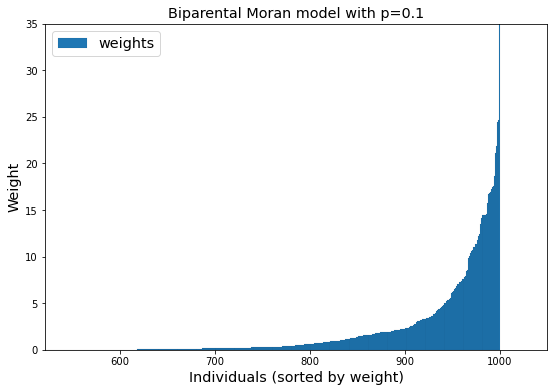

In [29]:
plt.bar(indices, weights_coupled[0], width=1, linewidth=0.05, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Biparental Moran model with p=0.1", fontsize="x-large")

ax = plt.gca()
ax.set_ylim([0, 35]) # Fix y-axis to be the same for all simulations for comparison
ax.set_xlim([np.where(weights_coupled[0] != 0)[0][0], None]) # Only show strictly positive weights
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.legend(fontsize="x-large")

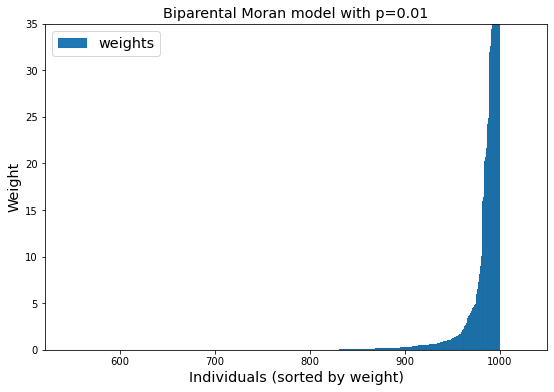

In [30]:
plt.bar(indices, weights_coupled[1], width=1, linewidth=0.05, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Biparental Moran model with p=0.01", fontsize="x-large")

ax = plt.gca()
ax.set_ylim([0, 35]) # Fix y-axis to be the same for all simulations for comparison
ax.set_xlim([np.where(weights_coupled[0] != 0)[0][0], None]) # Only show strictly positive weights
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.legend(fontsize="x-large")

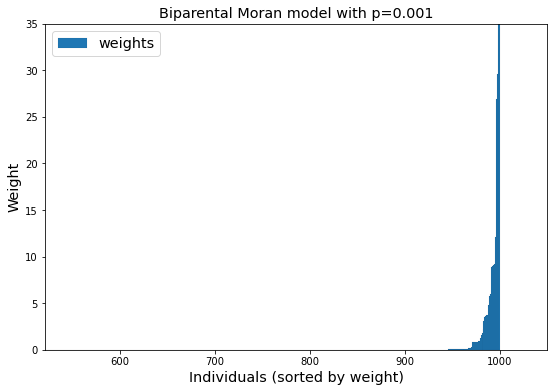

In [31]:
plt.bar(indices, weights_coupled[2], width=1, linewidth=0.05, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Biparental Moran model with p=0.001", fontsize="x-large")

ax = plt.gca()
ax.set_ylim([0, 35]) # Fix y-axis to be the same for all simulations for comparison
ax.set_xlim([np.where(weights_coupled[0] != 0)[0][0], None]) # Only show strictly positive weights
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.legend(fontsize="x-large")

# Biparental Moran with two children

In [33]:
def simulate_weights_moran_2_children(N, n):
    """
    Simulates weights of neutral (p1= 1/2 and p2=1/2) biparental Moran-type model with two children backwards in time.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        kappa, delta, pi, mu = rng.choice(indices, size=4, replace=False)
        Weights[pi] = Weights[pi] + (1/2)*Weights[kappa] + (1/2)*Weights[delta]
        Weights[mu] = Weights[mu] + (1/2)*Weights[kappa] + (1/2)*Weights[delta]
        Weights[kappa]=0
        Weights[delta]=0
    return Weights

### Example

In [34]:
start = time.time()

N = 10000
n = 1000000

indices = np.arange(0, N, 1, dtype=int)
weights_2children = simulate_weights_moran_2_children(N, n)
weights_2children.sort()

end = time.time()
print(str(round(end-start)) + " seconds")
print("Maximum weight: " + str(np.max(weights_2children)))
print("Number of zero-weights: " + str(np.where(weights_2children != 0)[0][0]))

16 seconds
Maximum weight: 18.627841059752097
Number of zero-weights: 6202


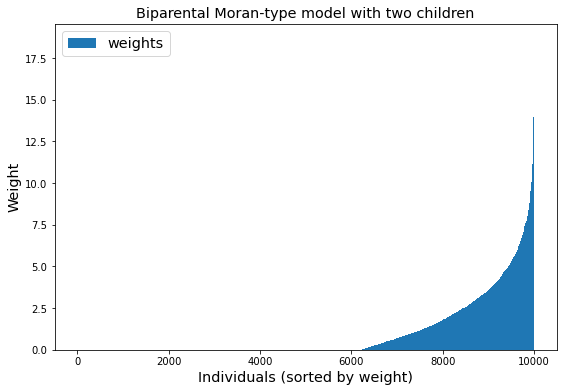

In [35]:
plt.bar(indices, weights_2children, width=1, linewidth=0, edgecolor="black", label = "weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Biparental Moran-type model with two children", fontsize="x-large")

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(9, 6)
#ax.set_ylim([0, 12])

plt.legend(fontsize="x-large")

# Biparental Wright-Fisher Model

In [36]:
def simulate_weights_wright_fisher(N, n):
    """
    Simulates weights of neutral biparental Wright-Fisher model backwards in time. Double Loop makes it slow.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        np.random.shuffle(indices)
        parents = np.random.randint(0, N/2, size=(N))
        w = np.zeros(N)
        counter = 0
        for j in parents:
            w[indices[2*j]] += 0.5*Weights[counter]
            w[indices[2*j+1]] += 0.5*Weights[counter]
            counter += 1
        Weights = w
    return Weights

# 5-parental Moran Model

In [37]:
def simulate_weights_moran_5_parents(N, n):
    """
    Simulates weights of neutral 5-parental Moran-type model backwards in time. rng.shuffle scales much wors in N 
    than rng.choice.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        rng.shuffle(indices)
        kappa=indices[0]
        pi=indices[1]
        mu=indices[2]
        alpha=indices[3]
        beta=indices[4]
        delta=indices[5]
        Weights[pi] = Weights[pi] + 0.2*Weights[kappa]
        Weights[mu] = Weights[mu] + 0.2*Weights[kappa]
        Weights[alpha] = Weights[alpha] + 0.2*Weights[kappa]
        Weights[beta] = Weights[beta] + 0.2*Weights[kappa]
        Weights[delta] = Weights[delta] + 0.2*Weights[kappa]
        Weights[kappa]=0
    return Weights

### Example

In [38]:
start = time.time()

N = 1000
n = 100000

indices = np.arange(0, N, 1, dtype=int)
weights_wf = simulate_weights_wright_fisher(N, n)
weights_m5 = simulate_weights_moran_5_parents(N, n)
weights_wf.sort()
weights_m5.sort()

end = time.time()
print(str(round(end-start)) + " seconds")
print("Maximum weight W-F: " + str(np.max(weights_wf)))
print("Maximum weight 5-Moran: " + str(np.max(weights_m5)))
print("Number of zero-weights W-F: " + str(np.where(weights_wf != 0)[0][0]))
print("Number of zero-weights 5-Moran: " + str(np.where(weights_m5 != 0)[0][0]))

170 seconds
Maximum weight W-F: 5.713661700573173
Maximum weight 5-Moran: 8.966774821936077
Number of zero-weights W-F: 210
Number of zero-weights 5-Moran: 197


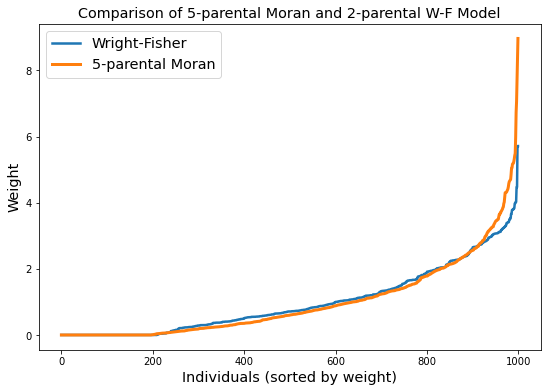

In [39]:
plt.plot(indices, weights_wf, linewidth=2.5, label = "Wright-Fisher")
plt.plot(indices, weights_m5, linewidth=3, label = "5-parental Moran")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Comparison of 5-parental Moran and 2-parental W-F Model", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.legend(fontsize="x-large")

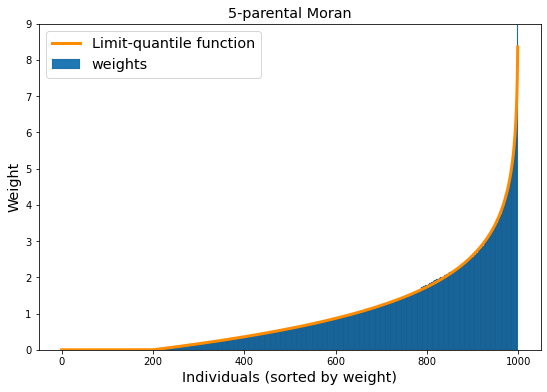

In [40]:
plt.bar(indices, weights_m5, width=1, linewidth=0.08, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("5-parental Moran", fontsize="x-large")

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(9, 6)
ax.set_ylim([0, 9])

#This part plots the Quantile function corresponding to the Limit (n,N -> inf) found by Camille Coron & Yves Le Jan.
#Here weights are 0 with probability 1/5 and otherwise EXP(4/5) distributed.
Quantiles = -(5/4)*np.log((5/4)*(1-indices[int((N*0.2)):]/N))
y = list(np.zeros(int((N*0.2))))
y.extend(Quantiles)
plt.plot(indices, y, color="darkorange", linewidth=3, label="Limit-quantile function")
plt.legend(fontsize="x-large")

# Biparental Moran model with sexes

In [41]:
def simulate_weights_moran_with_sexes(N, n):
    """
    Simulates weights of neutral Moran model with sexes backwards in time. N is half the population size.
    """
    Weights_male = np.ones(N)
    Weights_female = np.ones(N)
    indices_male = np.arange(0, N, 1, dtype=int)
    indices_female = np.arange(0, N, 1, dtype=int)
    for i in range(n):
        pi, kappa_male = rng.choice(indices_male, size=2, replace=False)
        mu, kappa_female = rng.choice(indices_female, size=2, replace=False)
        kappa_gender = np.random.randint(2)
        if kappa_gender == 0:
            Weights_male[pi] = Weights_male[pi] + (1/2)*Weights_male[kappa_male]
            Weights_female[mu] = Weights_female[mu] + (1/2)*Weights_male[kappa_male]
            Weights_male[kappa_male]=0
        if kappa_gender == 1:
            Weights_male[pi] = Weights_male[pi] + (1/2)*Weights_female[kappa_female]
            Weights_female[mu] = Weights_female[mu] + (1/2)*Weights_female[kappa_female]
            Weights_female[kappa_female]=0
    return np.append(Weights_male, Weights_female)

### Example

In [42]:
start = time.time()

N = 500
n = 100000

indices = np.arange(0, 2*N, 1, dtype=int)
weights_sexes = simulate_weights_moran_with_sexes(N, n)
weights_sexes.sort()

end = time.time()
print(str(round(end-start)) + " seconds")
print("Maximum weight: " + str(np.max(weights_sexes)))
print("Number of zero-weights: " + str(np.where(weights_sexes != 0)[0][0]))

3 seconds
Maximum weight: 13.732821724134592
Number of zero-weights: 481


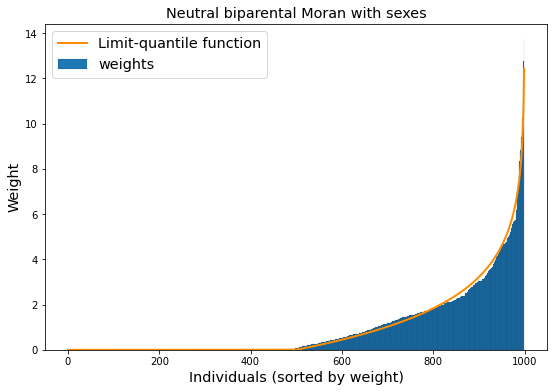

In [43]:
plt.bar(indices, weights_sexes, width=1, linewidth=0.08, edgecolor="black", label="weights")
plt.xlabel("Individuals (sorted by weight)", fontsize="x-large")
plt.ylabel("Weight", fontsize="x-large")
plt.title("Neutral biparental Moran with sexes", fontsize="x-large")

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(9, 6)

#This part plots the Quantile function corresponding to the Limit (n,N -> inf) found by Camille Coron & Yves Le Jan.
Quantiles = -(2)*np.log(2*(1-indices[int((N)):]/(2*N)))
y = list(np.zeros(int((N))))
y.extend(Quantiles)
plt.plot(indices, y, color="darkorange", linewidth=2, label="Limit-quantile function")
plt.legend(fontsize="x-large")

# Empirical moments compared to proven limit for different p

In [47]:
def compute_first_k_moments(k, p):
    """
    Computes first k moments of limiting distribution of a weight (N,n -> inf) according to limit proven in thesis.
    """
    moments = [-1]
    if k == 1:
        return np.array([1])
    for m in range(2, k+1):
        m_moment = 0
        for i in range(1,m):
            m_moment += (p**i + (1-p)**i)*moments[i-1]*moments[m-i-1]
        m_moment = m_moment / (1-p**m-(1-p)**m)
        moments.append(m_moment)
    return np.array(moments)*np.array([np.math.factorial(i)*(-1)**i for i in range(1,k+1)])

In [48]:
def estimate_first_k_moments(k, p, N=10000, n=1000000):
    """
    Estimates first k moments of simulated weights according to the standard moment method. These estimators 
    are unfortunately biased. Unbiased estimators could be computed for the centered moments.
    """
    est_moments = np.zeros(k)
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa]=0
        if (i % 10000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    weights = copy.deepcopy(Weights)
    for i in range(0, k):
        est_moments[i] = np.mean(weights)
        weights *= Weights
    return est_moments

### Example

In [49]:
# Computed moments of heuristically found limit for p=0.5
compute_first_k_moments(k=5, p=0.5)

array([1.00e+00, 4.00e+00, 2.40e+01, 1.92e+02, 1.92e+03])

In [50]:
# Moments of proven limit found by Camille Coron & Yves Le Jan
moments = []
for i in range(1, 6):
    moments.append(2**(i-1)*np.math.factorial(i))
moments

[1, 4, 24, 192, 1920]

### Example for p=0.25
#### Mean empirical moments over 15 tries compared to calculated moments proven in thesis

In [51]:
start = time.time()

moments_independent_sim = []
for i in range(15):
    moments_independent_sim.append(list(estimate_first_k_moments(8, 0.25, N=50000, n=1000000)))

moments_independent_sim = np.array(moments_independent_sim)    
#text_file = open("estimated_moments_p=0,25.txt", "w")
#text_file.write(np.array2string(moments_independent_sim))
#text_file.close()

means_of_moments = np.mean(moments_independent_sim, axis=0)
standard_errors = np.std(moments_independent_sim, axis=0) / np.sqrt(15)

end = time.time()
print(str(round((end-start)/60, 1)) + " minutes")

4.1 minutes


In [55]:
compute_first_k_moments(k=8, p=0.25)

array([1.00000000e+00, 5.33333333e+00, 4.62222222e+01, 5.47964240e+02,
       8.18764070e+03, 1.47200126e+05, 3.09014648e+06, 7.41587950e+07])

In [53]:
means_of_moments

array([1.00000000e+00, 5.32464173e+00, 4.60668181e+01, 5.46223497e+02,
       8.19146394e+03, 1.48377255e+05, 3.14383620e+06, 7.58590006e+07])

In [54]:
standard_errors

array([2.86658352e-17, 1.22051017e-02, 2.81140889e-01, 7.43927956e+00,
       2.40643422e+02, 8.46361028e+03, 3.07055171e+05, 1.13264853e+07])